In [1]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 4.8MB/s 
     |████████████████████████████████| 890kB 63.0MB/s 
     |████████████████████████████████| 3.8MB 56.0MB/s 
     |████████████████████████████████| 1.1MB 59.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/196-roBERTa_base/'

## Dependencies

In [5]:
import json, glob, warnings
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras import layers
from tensorflow.keras.models import Model

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64/fold_5.tar.gz'

In [7]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train,False


# Model parameters

In [8]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

with open(MODEL_BASE_PATH + 'config.json') as json_file:
     config = json.load(json_file)

config

{'BATCH_SIZE': 32,
 'EPOCHS': 7,
 'ES_PATIENCE': 3,
 'LEARNING_RATE': 3e-05,
 'MAX_LEN': 64,
 'N_FOLDS': 5,
 'base_model_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-tf_model.h5',
 'config_path': '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/qa-transformers/roberta/roberta-base-config.json',
 'question_size': 4}

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h08 = hidden_states[-5]
    
    x = layers.Dropout(.1)(h08)
    
    x_start = layers.Dense(1)(x)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    
    x_end = layers.Dense(1)(x)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Make predictions

In [0]:
k_fold_best = k_fold.copy()

for n_fold in range(config['N_FOLDS']):
    n_fold +=1

    # Load data                               
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Load model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    # Make predictions
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])

# Model evaluation

In [37]:
#@title
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.758274,0.705592,0.052682,0.772490,0.705490,0.767459,0.703057,0.760371,0.712029,0.744195,0.699818,0.746858,0.707566
Sentiment negative,0.619086,0.521926,0.097159,0.647940,0.510268,0.631305,0.520539,0.625239,0.531997,0.591482,0.518820,0.599462,0.528007
Sentiment neutral,0.977339,0.975011,0.002328,0.977580,0.976076,0.977438,0.975311,0.976832,0.975791,0.978005,0.972472,0.976839,0.975404
Sentiment positive,0.600698,0.523114,0.077584,0.619773,0.531820,0.618932,0.515704,0.602470,0.533688,0.579758,0.510840,0.582559,0.523518
0 <= text tokens < 3,0.958596,0.960171,-0.001575,0.960417,0.951923,0.956332,0.968254,0.955882,0.981481,0.970982,0.926471,0.949367,0.972727
3 <= text tokens < 20,0.786084,0.741731,0.044353,0.798427,0.739990,0.792634,0.744394,0.788307,0.750060,0.775244,0.729833,0.775806,0.744376
20 <= text tokens < 40,0.717246,0.652513,0.064733,0.733914,0.654745,0.729572,0.646004,0.719126,0.659391,0.698701,0.652018,0.704915,0.650406
40 <= text tokens < 64,0.690857,0.616433,0.074424,0.719694,0.601546,0.717039,0.549581,0.685950,0.580683,0.674592,0.646814,0.657008,0.703540
64 <= text tokens < 120,0.675214,0.621795,0.053419,0.666667,0.576923,0.688034,nan,0.666667,nan,0.688034,nan,0.666667,0.666667


# Visualize predictions

In [15]:
#@title
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,imputed
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,False
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,False
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,False
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,False
4,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,17,4,False
5,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,neutral,1.000000,27,27,False
6,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,0.071429,17,1,False
7,soooo high,soooo high,neutral,1.000000,3,3,False
8,both of you,both of you,neutral,1.000000,3,3,False
9,journey!? wow... u just became cooler. hehe... (is that possible!?),wow... u just became cooler.,positive,0.500000,19,7,False


## Post-processing evaluation

In [34]:
#@title
k_fold_best_post = k_fold_best.copy()
k_fold_best_post.loc[k_fold_best_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_best_post["text"]
print('\nImpute neutral')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_best_post = k_fold_best.copy()
k_fold_best_post.loc[k_fold_best_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_best_post["text"]
print('\nImpute <= 3')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_best_post = k_fold_best.copy()
k_fold_best_post.loc[k_fold_best_post['sentiment'] == 'neutral', 'selected_text'] = k_fold_best_post["text"]
k_fold_best_post.loc[k_fold_best_post['text_wordCnt'] <= 3, 'selected_text'] = k_fold_best_post["text"]
print('\nImpute neutral nao <= 3')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))

k_fold_best_post = k_fold_best.copy()
k_fold_best_post['selected_text'] = k_fold_best_post['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
k_fold_best_post['selected_text'] = k_fold_best_post['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
k_fold_best_post['selected_text'] = k_fold_best_post['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
print('\nImpute noise')
display(evaluate_model_kfold(k_fold_best_post, config['N_FOLDS']).head(1).style.applymap(color_map))


Impute neutral


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.763157,0.712074,0.051083,0.777206,0.711471,0.771427,0.707793,0.764166,0.717391,0.750690,0.709428,0.752296,0.714287



Impute <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.756724,0.705064,0.051660,0.770705,0.705195,0.765488,0.701010,0.758056,0.710099,0.743431,0.701370,0.745941,0.707645



Impute neutral nao <= 3


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.762215,0.711900,0.050315,0.775939,0.711865,0.770190,0.706883,0.762436,0.715874,0.750522,0.710474,0.751989,0.714403



Impute noise


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.755574,0.703165,0.052409,0.769812,0.702647,0.764747,0.699039,0.757530,0.710281,0.741466,0.698542,0.744316,0.705317


# Error analysis

## 10 worst predictions

In [17]:
#@title
k_fold_best['jaccard_mean'] = (k_fold_best['jaccard_fold_1'] + k_fold_best['jaccard_fold_2'] + 
                               k_fold_best['jaccard_fold_3'] + k_fold_best['jaccard_fold_4'] + 
                               k_fold_best['jaccard_fold_4']) / 5

display(k_fold_best[['text', 'selected_text', 'sentiment', 'jaccard', 'jaccard_mean', 
                     'prediction_fold_1', 'prediction_fold_2', 'prediction_fold_3', 
                     'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

,text,selected_text,sentiment,jaccard,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
15157,"that`s family for you imna crash, woke up 630 3 days in a row....lol",a crash,negative,0.066667,0.0,"imna crash,","crash,","imna crash,","crash,","crash,"
10227,yess... it`s awesomee.. and u can follow ur love molly hahah.... now u can chat with us here!,s awesomee,positive,0.000000,0.0,awesomee..,awesomee..,awesomee..,awesomee..,it`s awesomee..
15502,@_hayles are u serious???? you touched his ****? ohmygod u ****!!! lol aaaaawwwwwww y did u tell me that!!!,****!!,negative,0.000000,0.0,ohmygod u ****!!!,ohmygod u ****!!!,ohmygod u ****!!!,aaaaawwwwwww,ohmygod u ****!!!
17246,rofl,rofl,neutral,1.000000,0.0,ro,ro,ro,ro,ro
4638,it was great to meet ya katie...awesome shows for sure!! safe travels home.,.awesome,positive,0.000000,0.0,it was great to meet ya katie...awesome shows for sure!!,wesome shows for sure!!,great,great,it was great
17247,"yeah, tried it. no go.",tried,negative,0.200000,0.0,no go.,no go.,no go.,no go.,no go.
26313,had plans with people but they cancelled...now what to do?,cancelled..,negative,0.000000,0.0,cancelled...,cancelled...,cancelled...,cancelled...,cancelled...
26307,ahh im in love. hes theeee best.,best.,positive,0.142857,0.0,ahh im in love.,ahh im in love.,ahh im in love.,ahh im in love.,ahh im in love.
17257,n case you missed the show yesterday - here`s a chance to listen again on the bbc iplayer enjoy http://tiny.cc/oikbk,here`s a chance to listen again on,positive,0.368421,0.0,enjoy,enjoy,enjoy,enjoy,enjoy
10675,yes,yes,neutral,1.000000,0.0,,,,,


# Sentiment

In [18]:
#@title
print('\n sentiment == neutral')
display(k_fold_best[k_fold_best['sentiment'] == 'neutral'][['text', 'selected_text', 
                                                            'jaccard_mean', 'prediction_fold_1', 
                                                            'prediction_fold_2', 'prediction_fold_3', 
                                                            'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == positive')
display(k_fold_best[k_fold_best['sentiment'] == 'positive'][['text', 'selected_text', 
                                                            'jaccard_mean', 'prediction_fold_1', 
                                                            'prediction_fold_2', 'prediction_fold_3', 
                                                            'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))

print('\n sentiment == negative')
display(k_fold_best[k_fold_best['sentiment'] == 'negative'][['text', 'selected_text', 
                                                            'jaccard_mean', 'prediction_fold_1', 
                                                            'prediction_fold_2', 'prediction_fold_3', 
                                                            'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(10))


 sentiment == neutral


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
11455,yup,yup,0.0,,,,,
25690,@_cheshire_cat_,_cheshire_cat_,0.0,@_cheshire_cat_,@_cheshire_cat_,@_cheshire_cat_,@_cheshire_cat_,@_cheshire_cat_
16473,not,not,0.0,,,,,
3262,_inthemaking :aw,aw,0.0,_inthemaking :aw,_inthemaking :aw,_inthemaking :aw,_inthemaking :aw,_inthemaking :aw
3446,why?,why?,0.0,why,why,why,why,why
12361,ikr!!!,ikr!!!,0.0,kr,kr,kr,kr,kr
24209,byeeeee!!!,byeeeee!!,0.0,byeeeee!!!,byeeeee!!!,byeeeee!!!,byeeeee!!!,byeeeee!!!
24068,g`night!,g`night,0.0,g`night!,g`night!,g`night!,g`night!,g`night!
17246,rofl,rofl,0.0,ro,ro,ro,ro,ro
23659,why?,why?,0.0,why,why,why,why,why



 sentiment == positive


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
24504,http://twitpic.com/4hsd2 - weheyyyy we give thanks for midi keyboards,ve thank,0.0,give thanks,we give thanks,we give thanks,we give thanks,we give thanks
20565,now i know my shares are up...have 7 followers...wonderful! the sun is now shining brightly in `darkest africa`...,wonderful! the sun is now shining brightly in `darkest africa,0.0,onderful!,onderful!,onderful!,onderful!,onderful!
6685,"good morning miamiadc my weekend was great and i just had my monday, which was also great i hope you have a wonder...",a wonderfu,0.0,good morning miamiadc my weekend was great,my weekend was great,my weekend was great,good morning miamiadc my weekend was great,good morning miamiadc my weekend was great
23637,"thanks for that, now i learned something new today enjoy.",enjoy,0.0,"thanks for that,","thanks for that, now i learned something new today enjoy.","thanks for that, now i learned something new today enjoy.","thanks for that, now i learned something new today enjoy.","thanks for that, now i learned something new today enjoy."
13802,forgot she had a twitter account. happy mother`s day!,happ,0.0,happy,happy,happy,happy,happy
10998,is maxin and relaxin... ahhh,relaxin..,0.0,relaxin... ahhh,ahhh,relaxin...,relaxin...,relaxin...
23616,just saw it tonight as well... great movie!! hope you`re well mate! cheers e,.. grea,0.0,great movie!!,great movie!!,great movie!!,great movie!!,great movie!!
20655,he he ...happy #star wars day! may the 4th be with you brilliant!!,happy #star wars day!,0.0,appy,appy,appy,appy,appy
5188,http://twitpic.com/4wc1y - cracking myself more & more up.. phootoboothingisfunforbunny volumen eins!,sfunf,0.0,cracking,phootoboothingisfunforbunny volumen eins!,cracking myself more & more up.. phootoboothingisfunforbunny volumen eins!,cracking myself more & more up.. phootoboothingisfunforbunny volumen eins!,cracking myself more & more up..
8002,_d awww glad to know little sweet d and leigh are doing good...thanks for the updates howie,little sweet d and leigh are doing good...thanks for the updates ho,0.0,glad,glad,glad,glad,glad



 sentiment == negative


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
9725,my tummy hurts...again,hurts..,0.0,hurts...,hurts...,hurts...,hurts...again,hurts...again
22985,y am i still awake!!!! smh.... this sucks!!!,sucks!!,0.0,sucks!!!,sucks!!!,sucks!!!,sucks!!!,sucks!!!
19780,i think my modem failed-having pc withdrawals..,i think my modem failed-having pc withdrawals..,0.0,failed-,failed-,failed-,failed-,failed-
3671,is not feelin well... i feel sooooo weak....i hate bein sick in the summer,weak..,0.0,i feel sooooo weak....i hate bein sick in the summer,hate bein sick in the summer,weak....,hate bein sick in the summer,is not feelin well... i feel sooooo weak....
1149,but they are expensive.,e expensive,0.0,expensive.,expensive.,expensive.,expensive.,expensive.
15735,i know what you mean rain sucks...,n sucks,0.0,rain sucks...,rain sucks...,rain sucks...,rain sucks...,rain sucks...
3677,migranes suck....especially when the kids are suddenly hyper.,suck..,0.0,suck....,suck....,suck....,suck....,suck....
9838,is so frustrated!!! i`m stuck at home without any transportation to the global god conference!!! ahh,so frustrated!!,0.0,frustrated!!!,frustrated!!!,frustrated!!!,frustrated!!!,frustrated!!!
22948,"srsly, bgt, joke maaan. how lame. ughhhh work tomorah have to get up early",ughhhh,0.0,lame.,lame.,lame.,how lame.,how lame.
26053,"ohhhh, how sad...i didnï¿½t get it!",sad..,0.0,sad...,sad...,sad...,"ohhhh, how sad...",sad...


# text_tokenCnt

In [19]:
#@title
display(k_fold_best[k_fold_best['text_tokenCnt'] <= 3][['text', 'selected_text', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))

display(k_fold_best[k_fold_best['text_tokenCnt'] >= 50][['text', 'selected_text', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))

,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
25698,me,me,0.0,,,,,
26369,bye.,bye.,0.0,bye,bye,bye,bye,bye
8766,awww,awww,0.0,a,a,a,a,a
16641,goodnight!!!,goodnight!!,0.0,goodnight!!!,goodnight!!!,goodnight!!!,goodnight!!!,goodnight!!!
14338,ow,ow,0.0,,,,,


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
21141,grrrr!!! it`s back!!!!! and what i mean is my headache but on the * * bright side....it`s only on one ...,grrrr!!,0.000000,grrrr!!!,grrrr!!! it`s back!!!!! and what i mean is my headache,grrrr!!!,grrrr!!!,grrrr!!!
8616,brooklyn!!! we went hard!!! now back up top!! but 1st hajji`s...yea again http://tinyurl.com/codla7 http://ti.. htt...,hard!!,0.000000,hard!!!,hard!!!,hard!!!,we went hard!!!,we went hard!!!
10091,.ï¿½ï¿½?????ï¿½ï¿½. i bet. man i wish i coulda went some whr. i didn`t even go out here. i was home all weekend. n...,nd. nyt life sux,0.231579,i wish i coulda went some whr. i didn`t even go out here. i was home all weekend. nyt life sux,sux,sux,sux,sux
4106,"thank a chu?t ï¿½ ch?c v?y quï¿½, hik, ch?c em ph?i ?i h?c 1 khï¿½a ph? c?p ki?n th?c c? khï¿½ g?p =.=",thank a chu?,0.333333,thank,thank,thank,thank,thank
3746,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray f.. http://bit.l...",prayin,0.440000,prayin,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray",prayin,"prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray","prayin for dad in wellington, fl http://loopt.us/f8_jqg.t (via ). i too live in welly. may i pray"


# selected_text_tokenCnt

In [20]:
#@title
print('\n selected_text_tokenCnt <= 3')
display(k_fold_best[k_fold_best['selected_text_tokenCnt'] <= 3][['text', 'selected_text', 
                                                        'jaccard_mean', 'prediction_fold_1', 
                                                        'prediction_fold_2', 'prediction_fold_3', 
                                                        'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))
print('\n selected_text_tokenCnt >= 50')
display(k_fold_best[k_fold_best['selected_text_tokenCnt'] >= 50][['text', 'selected_text', 
                                                                  'jaccard_mean', 'prediction_fold_1', 
                                                                  'prediction_fold_2', 'prediction_fold_3', 
                                                                  'prediction_fold_4', 'prediction_fold_5']].sort_values(by=['jaccard_mean']).head(5))


 selected_text_tokenCnt <= 3


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
13226,"you guys were absolutely amazing tonight, as always. thanks for always bringing the dance party.",ly amazin,0.0,you guys were absolutely amazing,amazing,amazing,amazing,you guys were absolutely amazing
26427,**** that is awful... could not believe it at first... so sad,awful.,0.0,**** that is awful...,**** that is awful...,**** that is awful...,**** that is awful...,**** that is awful...
18772,give them my best!,y best,0.0,best!,best!,best!,best!,best!
22450,cool!!! no wonder you didn`t sleep much,cool!,0.0,cool!!!,cool!!!,cool!!!,cool!!!,cool!!!
12521,"saying goodbye to a good trusted friend today. goodbye free sky tv, you were the best friend anyone could have had.",goodb,0.0,you were the best friend anyone could have had.,you were the best friend anyone could have had.,"good trusted friend today. goodbye free sky tv, you were the best friend anyone could have had.","good trusted friend today. goodbye free sky tv, you were the best friend anyone could have had.","good trusted friend today. goodbye free sky tv, you were the best friend anyone could have had."



 selected_text_tokenCnt >= 50


,text,selected_text,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
24998,"???? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edeno...","???? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edeno...",0.633333,"??? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edenof...","??? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edenof...","??? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edenof...","??? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edenof...","??? ? ??????, ?????? ????????,basquash,k-on,07-ghost,sengoku basara,valkyria chronicles,requiemforthephantom,edenof..."
3292,"legend of inotia ??????? ??????. ?????? ???????. ???? ??????? 31? ?????, ????? ?????? ???. ????????? ???? ?????? ???...","legend of inotia ??????? ??????. ?????? ???????. ???? ??????? 31? ?????, ????? ?????? ???. ????????? ???? ?????? ???...",0.685714,legend of inotia,legend of inotia,"legend of inotia ??????? ??????. ?????? ???????. ???? ??????? 31? ?????, ????? ?????? ???. ????????? ???? ?????? ???...","legend of inotia ??????? ??????. ?????? ???????. ???? ??????? 31? ?????, ????? ?????? ???. ????????? ???? ?????? ???...",legend of inotia
15551,"yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng , th?ch sanh nh? lï¿½m quiz mï¿½ c??i ...","yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng , th?ch sanh nh? lï¿½m quiz mï¿½ c??i ...",0.687179,"yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng","yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng , th?ch sanh nh?","yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng , th?ch sanh nh","yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng , th?ch sanh nh?","yï¿½n tï¿½m, sang n?m s? th?y **** m?c tr?n tinh twitter tr? l?i lï¿½ thï¿½ng , th?ch sanh nh"
27317,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,0.978571,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...,just saw an advert for attics to eden on tv out today and only ï¿½9.99 from hmv...so i`m not sure why i had to pay ...
1586,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,1.000000,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...,link per my daughter us.mobile.reuters.com/mobile/m/anyarticle/p.rdt?url=http://www.reuters.com/article/bigmoney/id...


# Jaccard histogram

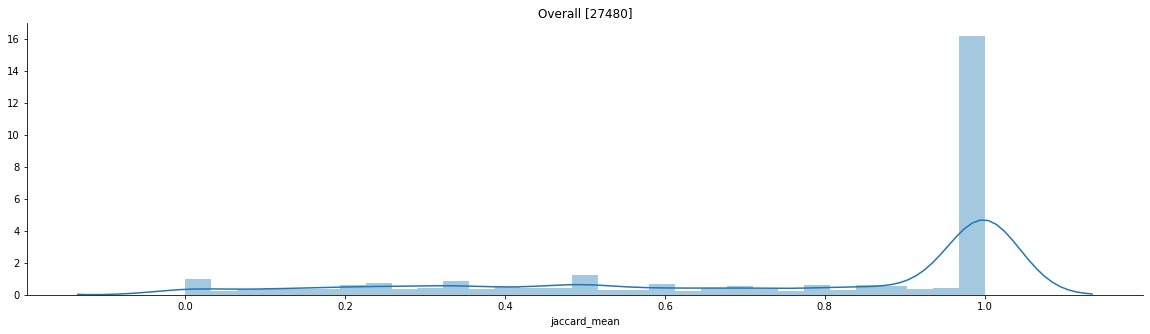

In [21]:
#@title
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.distplot(k_fold_best['jaccard_mean'], ax=ax).set_title(f"Overall [{len(k_fold_best)}]")
sns.despine()
plt.show()

## By sentiment

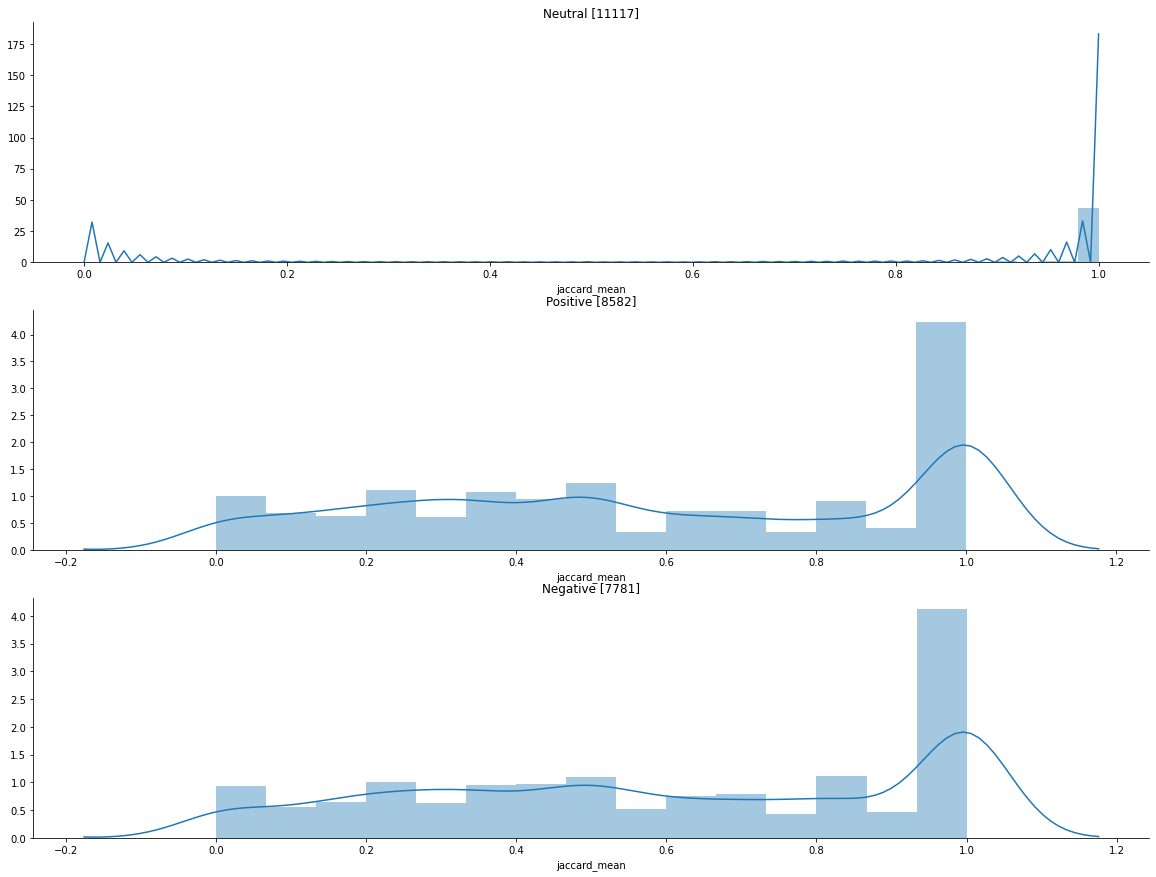

In [22]:
#@title
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=False)
sns.distplot(k_fold_best[k_fold_best['sentiment'] == 'neutral']['jaccard_mean'], ax=ax1).set_title(f"Neutral [{len(k_fold_best[k_fold_best['sentiment'] == 'neutral'])}]")
sns.distplot(k_fold_best[k_fold_best['sentiment'] == 'positive']['jaccard_mean'], ax=ax2).set_title(f"Positive [{len(k_fold_best[k_fold_best['sentiment'] == 'positive'])}]")
sns.distplot(k_fold_best[k_fold_best['sentiment'] == 'negative']['jaccard_mean'], ax=ax3).set_title(f"Negative [{len(k_fold_best[k_fold_best['sentiment'] == 'negative'])}]")
sns.despine()
plt.show()

## By text token count

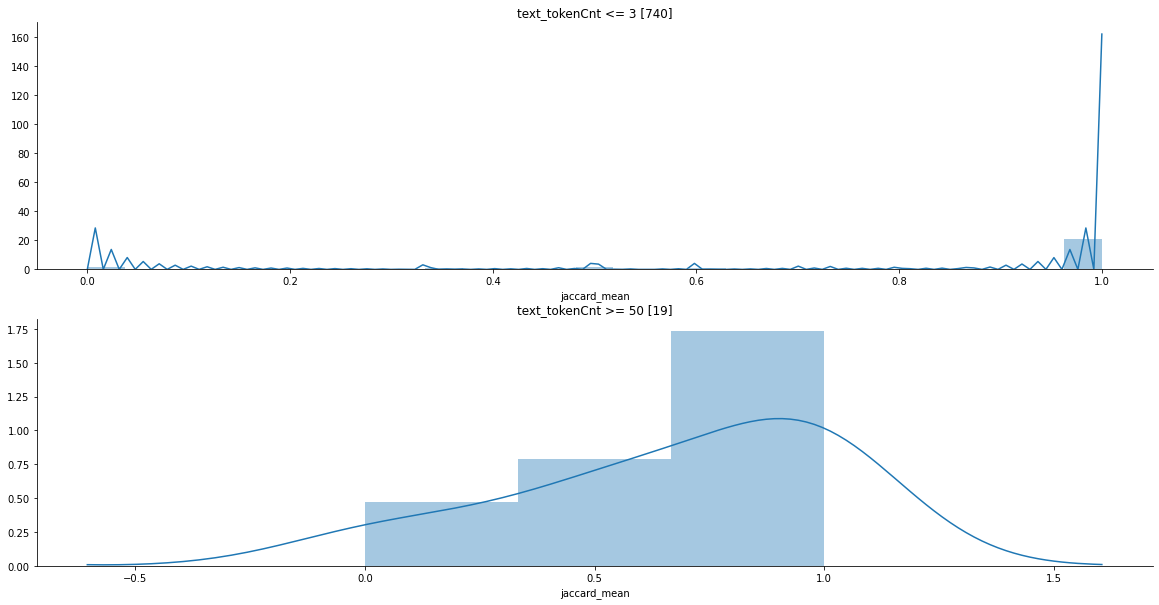

In [23]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold_best[k_fold_best['text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"text_tokenCnt <= 3 [{len(k_fold_best[k_fold_best['text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold_best[k_fold_best['text_tokenCnt'] >= 50]['jaccard_mean'], ax=ax2).set_title(f"text_tokenCnt >= 50 [{len(k_fold_best[k_fold_best['text_tokenCnt'] >= 50])}]")
sns.despine()
plt.show()

## By selected_text token count

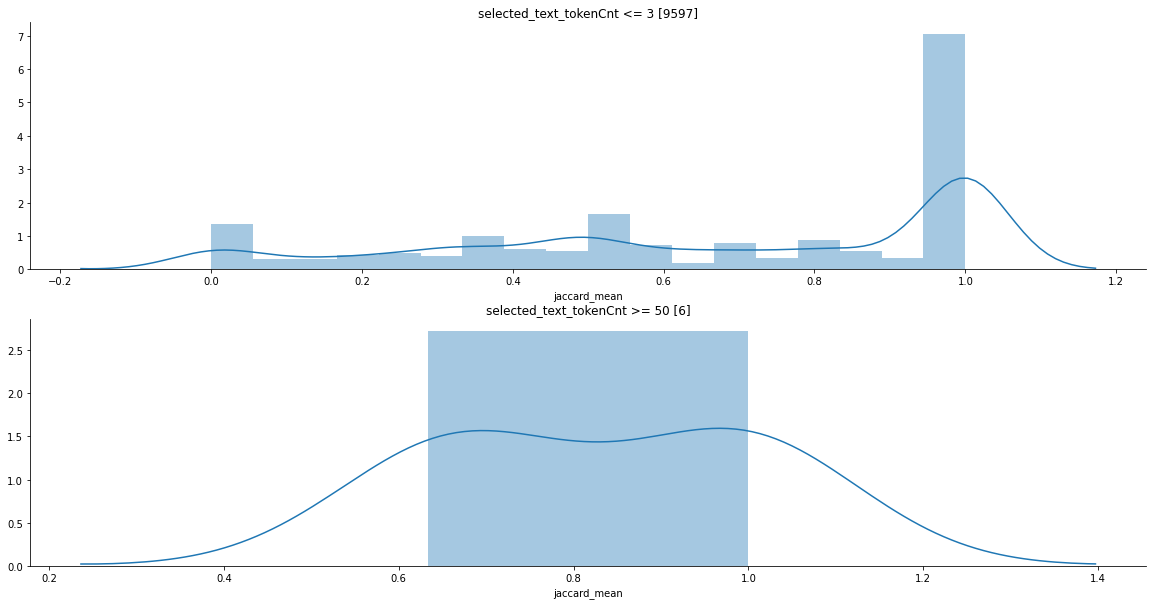

In [24]:
#@title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=False)
sns.distplot(k_fold_best[k_fold_best['selected_text_tokenCnt'] <= 3]['jaccard_mean'], ax=ax1).set_title(f"selected_text_tokenCnt <= 3 [{len(k_fold_best[k_fold_best['selected_text_tokenCnt'] <= 3])}]")
sns.distplot(k_fold_best[k_fold_best['selected_text_tokenCnt'] >= 50]['jaccard_mean'], ax=ax2).set_title(f"selected_text_tokenCnt >= 50 [{len(k_fold_best[k_fold_best['selected_text_tokenCnt'] >= 50])}]")
sns.despine()
plt.show()